# Probabilistic Methods (Discrete)

<hr style="border:2px solid gray">

In [142]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import env

import warnings
warnings.filterwarnings("ignore")

When you have a variable that is not too noisy, you can have a baseline probability, then as new datapoints come in you can identify and compare the actual rate with the expected rate (probability).

<hr style="border:2px solid gray">

# Acquire the data

Ada, was Codeup's first Data Science cohort! The data comes from the webserver logs of the API that we used in the timeseries module. Each row is one request to the server.

In [143]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

In [144]:
#get url connection
url = f'mysql+pymysql://{env.username}:{env.password}@{env.host}/logs'
#read in from sql
df = pd.read_sql('SELECT * FROM api_access', url)
#parse data using function above
df = df.entry.apply(parse_log_entry)
#take a look
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


<b> For the sake of this lesson we will create some sythetic records and append them to our existing data frame.

In [145]:
#create new dataframe with fake data
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

#add the new dataframe we created to the original Ada information
new_df = pd.concat([new, df])

In [146]:
new_df.sample(5)

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
796,97.105.19.58,16/Apr/2019 19:46:44,GET,/api/v1/sales?page=10,HTTP/1.1,200,500113,python-requests/2.21.0
1815,97.105.19.58,16/Apr/2019 19:55:59,GET,/api/v1/sales?page=76,HTTP/1.1,200,510134,python-requests/2.21.0
6639,97.105.19.58,16/Apr/2019 20:56:52,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
11526,97.105.19.58,16/Apr/2019 22:40:50,GET,/api/v1/sales?page=137,HTTP/1.1,200,511176,python-requests/2.21.0
11365,97.105.19.58,16/Apr/2019 22:37:18,GET,/api/v1/sales?page=126,HTTP/1.1,200,510458,python-requests/2.21.0


<hr style="border:2px solid gray">

# Detecting Anomalies in Discrete Variables
<b>Anomaly Detection</b>: Identification of items, events or observations which is significantly different from the remaining data.

To detect anomalies in descrete variables we can look at <u>two</u> ways of summarizing the variable:
- <b>Count</b>: the number of times each unique value appears in the dataset
    - (ex): How many time a value of variable (e.g. ip address) shows up?
- <b>Frequencies</b>: the number of times each unique value appears in the dataset as a percentage of the total; the count divided by the total number of observations
    - <u>More</u> frequently occuring - <i>less</i> likely to be an anomaly
    - <u>Less</u> frequently occuring - <i>more</i> likely to be an anomaly

<hr style="border:1px solid gray">

<b>Examples of each type of Anomaly Detection technique</b>:
- How many times we see an ip address in the dataset
    - count how many times that ip address logs in
- What is probability of ip address showing up in the dataset
    - ip count / total observations
- Conditional probability. Given an ip address, what is prob of a particular status
    - probability of A, given that B is true
    - e.g authentication failure

### Let's take a look at ```ip``` using the count and frequency methods 

In [147]:
#a count of each ip address
new_df.ip.value_counts().head()

ip
97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
24.26.242.9          21
Name: count, dtype: int64

In [148]:
#what percent is that of the dataset
new_df.ip.value_counts(normalize=True).head()

ip
97.105.19.58      0.858420
173.173.113.51    0.075762
72.181.113.170    0.043855
72.181.105.81     0.017599
24.26.242.9       0.001502
Name: proportion, dtype: float64

In [149]:
#turn this into a dataframe
ip_df = pd.DataFrame(new_df.ip.value_counts(dropna=False)).reset_index().\
                rename(columns={'index': 'ip', 'ip': 'count'})

ip_df

,count,count
0,97.105.19.58,11999
1,173.173.113.51,1059
2,72.181.113.170,613
3,72.181.105.81,246
4,24.26.242.9,21
5,68.201.219.223,21
6,52.87.230.102,2
7,70.121.214.34,2
8,35.175.171.137,2
9,95.31.18.119,1


<b>We can define a function that combines both these pieces of information:</b>

In [150]:
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )

In [151]:
#create a dataframe of actual count and percentage of occurances
ip_df = value_counts_and_frequencies(new_df.ip)
ip_df.head()

,count,proba
ip,,
97.105.19.58,11999,0.858420
173.173.113.51,1059,0.075762
72.181.113.170,613,0.043855
72.181.105.81,246,0.017599
24.26.242.9,21,0.001502


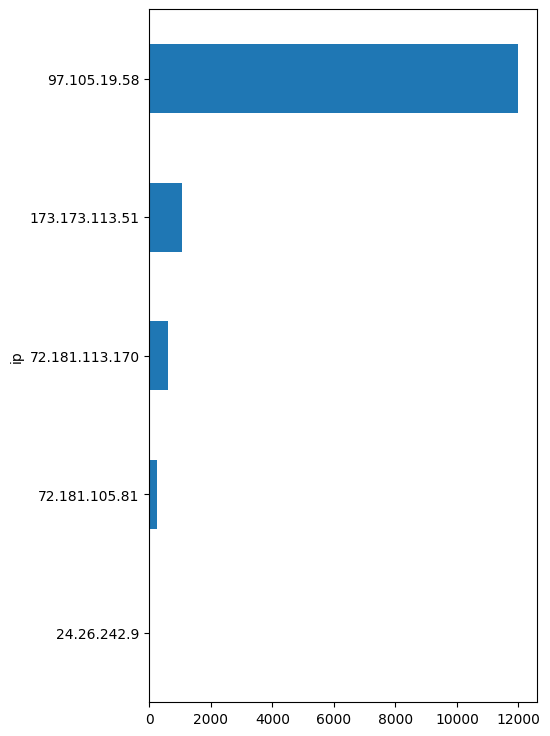

In [162]:
#Let's visualize this
ip_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))
None

#### Takeaway

It looks like <u>one</u> ip address is accounting for almost 86% of the hits to the codeup curriculum.

<hr style="border:1px solid gray">

### Conditional Probabilities: Probabilities using 2 discrete variables

<b>prob(A|B) = prob(A&B)/prob(B)</b>

If we are looking for an unexpected status (like authentication failure) from a known/common IP address.


<b>HTTP Status Codes</b>

- 200: ok
- 3xx: redirects
- 4xx: client level errors -- the requester did something wrong
- 5xx: server level errors -- the server did something wrong


<b>What is probability of a certain status code given an IP address?

In [153]:
#look at ip address, their status and the probability it will be that status
status_given_ip = (
    new_df.groupby('ip')
    .status_code.value_counts(normalize=True)
    .rename('proba_status_given_ip')
    .reset_index()
)
status_given_ip.head()

,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.0
1,24.26.242.9,200,1.0
2,3.88.129.158,200,1.0
3,3.92.201.136,200,1.0
4,34.207.64.242,200,1.0


In [154]:
#what about statuses that are NOT successful?
status_given_ip[status_given_ip.status_code != '200']

,ip,status_code,proba_status_given_ip
18,72.181.113.170,499,0.003263
19,95.31.16.121,301,1.000000
21,97.105.15.120,301,1.000000
23,97.105.19.58,499,0.001167


<b>This is interesting -- we have detected two ip addresses who only received 301 response codes. Let's investigate one further:

In [155]:
#what about ips that had different statuses
status_given_ip[status_given_ip.proba_status_given_ip < 1]

,ip,status_code,proba_status_given_ip
17,72.181.113.170,200,0.996737
18,72.181.113.170,499,0.003263
22,97.105.19.58,200,0.998833
23,97.105.19.58,499,0.001167


<b>This is interesting -- 72.181.113.170 was successful on most attempts but not all. Same applies to 97.105.19.58

### Let's investigate Further

In [156]:
#why is this ip address only returning 301 errors??
new_df[new_df.ip =='97.105.15.120']

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
2,97.105.15.120,18/Apr/2019 19:42:41,GET,/api/v1/sales?page=79/,HTTP/1.1,301,2560,python-requests/2.21.0



<b>Takeaways:</b>

If the probability of a status given the ip address is 100%, we know that that was the only status code seen by that ip address. To detect anomalies here we could look for two things:
- Cases where the probability is < 100% -- this means that multiple different status codes were encountered from the given ip address
<br>

    <b>OR</b>
<br>

- Status codes other than 200. 200 is the most common response code in our dataset by far.


<hr style="border:2px solid gray">

## Using the original ADA dataframe (with no new entries)

In [157]:
#make sure the original has 4 less entries
len(df), len(new_df)

(13974, 13978)

In [158]:
#look at ip address, their status and the probability it will be that status
og_status_given_ip = (
    df.groupby('ip')
    .status_code.value_counts(normalize=True)
    .rename('proba_status_given_ip')
    .reset_index()
)
og_status_given_ip.sample(10)

,ip,status_code,proba_status_given_ip
14,68.201.219.223,200,1.000000
19,97.105.19.58,200,0.998833
13,54.172.14.223,200,1.000000
5,34.229.70.250,200,1.000000
6,35.174.209.2,200,1.000000
12,54.145.52.184,200,1.000000
16,72.181.105.81,200,1.000000
18,72.181.113.170,499,0.003263
3,3.92.201.136,200,1.000000
9,52.87.230.102,200,1.000000


In [159]:
# Essentially a list of the probability of each ip/status code combination
og_status_given_ip

,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.000000
1,24.26.242.9,200,1.000000
2,3.88.129.158,200,1.000000
3,3.92.201.136,200,1.000000
4,34.207.64.242,200,1.000000
5,34.229.70.250,200,1.000000
6,35.174.209.2,200,1.000000
7,35.175.171.137,200,1.000000
8,45.23.250.16,200,1.000000
9,52.87.230.102,200,1.000000


In [160]:
#set date to index, merge on ip and status
df = df.reset_index().merge(status_given_ip, on=['ip', 'status_code'], how='left').fillna(value=0).set_index('timestamp')

In [161]:
#only give me the ips that have less than 15% unsuccessful accesses
df[df.proba_status_given_ip < 0.15]

,index,ip,request_method,request_path,http_version,status_code,size,user_agent,proba_status_given_ip
timestamp,,,,,,,,,
16/Apr/2019 19:55:15,1745,97.105.19.58,GET,/api/v1/sales?page=2,HTTP/1.1,499,0,python-requests/2.20.1,0.001167
16/Apr/2019 19:56:02,1819,97.105.19.58,GET,/api/v1/sales?page=21,HTTP/1.1,499,0,python-requests/2.20.1,0.001167
16/Apr/2019 20:28:46,4242,97.105.19.58,GET,/api/v1/sales?page=2,HTTP/1.1,499,0,python-requests/2.21.0,0.001167
16/Apr/2019 20:33:24,4405,97.105.19.58,GET,/api/v1/sales?page=29,HTTP/1.1,499,0,python-requests/2.21.0,0.001167
16/Apr/2019 20:38:13,4790,97.105.19.58,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0,0.001167
16/Apr/2019 20:38:55,4862,97.105.19.58,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0,0.001167
16/Apr/2019 20:39:00,4871,97.105.19.58,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0,0.001167
16/Apr/2019 20:45:17,5520,97.105.19.58,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0,0.001167
16/Apr/2019 20:45:28,5539,97.105.19.58,GET,/api/v1/sales?page=2,HTTP/1.1,499,0,python-requests/2.21.0,0.001167


<b>All low probability combinations are now easily identifiable with all additional data intact.

<b>All of these IPs have low probability of failure